In this competition, i will be using Kaggle platform for modelling (GPU and internet enabled). The libraries i will be using are fastai datablock api which is built on Pytorch. please visit [here](https://www.fast.ai//) for all the course materials.
Thanks to `Jeremy Howard` and `Rachel Thomas`.


### Load libraries and read the data

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# from sklearn.metrics import f1_score
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
import seaborn as sns
import matplotlib.pyplot as plt
import os
import cv2
import glob
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['train', 'test_ApKoW4T.csv', 'sample_submission_ns2btKE.csv']


- lets import the fastai libraries 

In [2]:
from pathlib import Path
from fastai import *
from fastai.vision import *
import torch
from fastai.callbacks.hooks import *

In [3]:
## set the data folder
data_folder = Path("../input")

In [4]:
data_path = "../input/train/images/"
path = os.path.join(data_path , "*jpg")

In [5]:
files = glob.glob(path)
data=[]
for file in files:
    image = cv2.imread(file)
    data.append(image)

In [6]:
## read the csv data files
train_df = pd.read_csv('../input/train/train.csv')
test_df = pd.read_csv('../input/test_ApKoW4T.csv')
submit = pd.read_csv('../input/sample_submission_ns2btKE.csv')

In [7]:
train_df.shape, test_df.shape

((6252, 2), (2680, 1))

In [8]:
train_df.head()

,image,category
0,2823080.jpg,1
1,2870024.jpg,1
2,2662125.jpg,2
3,2900420.jpg,3
4,2804883.jpg,2


In [9]:
test_df.head()

,image
0,1007700.jpg
1,1011369.jpg
2,1051155.jpg
3,1062001.jpg
4,1069397.jpg


In [10]:
# submit.head()

In [11]:
train_df.groupby('category').count()

,image
category,
1,2120
2,1167
3,916
4,832
5,1217


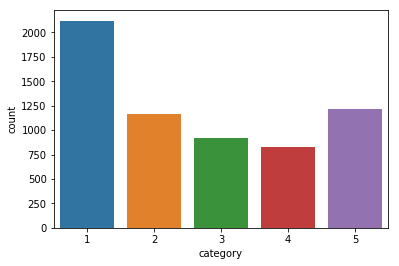

In [12]:
sns.countplot(x='category' , data=train_df)

- we have 5 categories as mentioned in the problem

In [13]:
train_images = data[:6252]
test_images= data[6252:]

In [14]:
## mapping the ship categories  
category = {'Cargo': 1, 
'Military': 2, 
'Carrier': 3, 
'Cruise': 4, 
'Tankers': 5}

- we will plot pictures from all the classes to look at those cool ships

In [15]:
def plot_class(cat):
    
    fetch = train_df.loc[train_df['category']== category[cat]][:3]
    fig = plt.figure(figsize=(20,15))
    
    for i , index in enumerate(fetch.index ,1):
        plt.subplot(1,3 ,i)
        plt.imshow(train_images[index])
        plt.xlabel(cat + " (Index:" +str(index)+")" )
    plt.show()

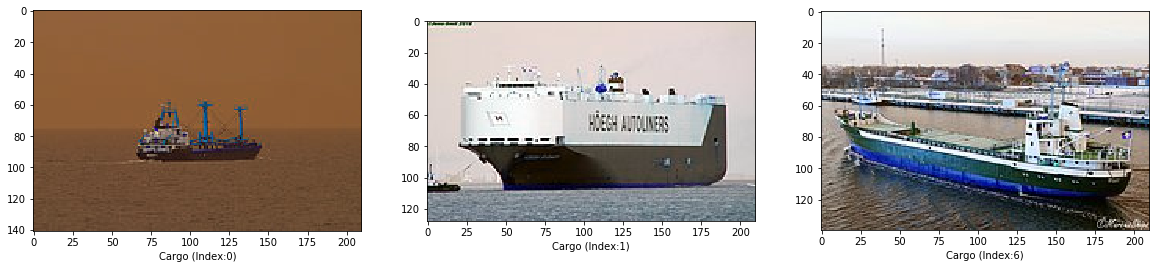

In [16]:
plot_class('Cargo')

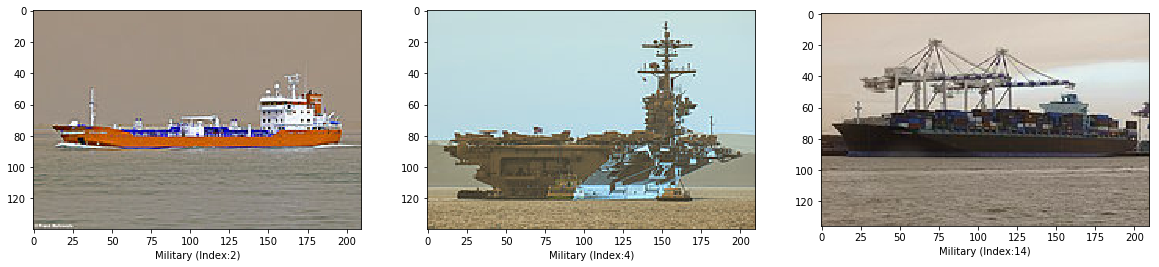

In [17]:
plot_class('Military')

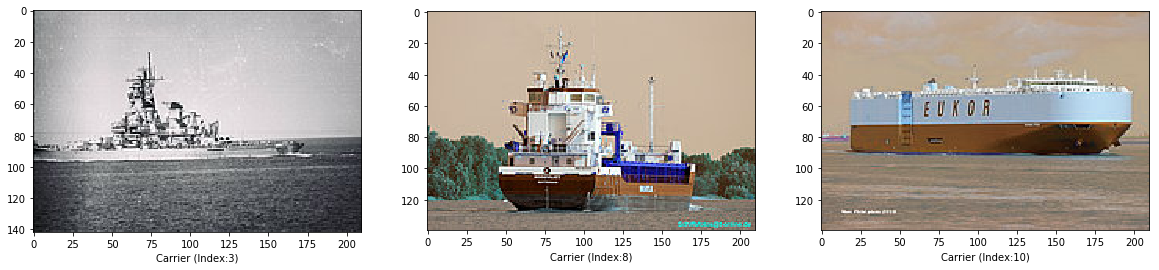

In [18]:
plot_class('Carrier')

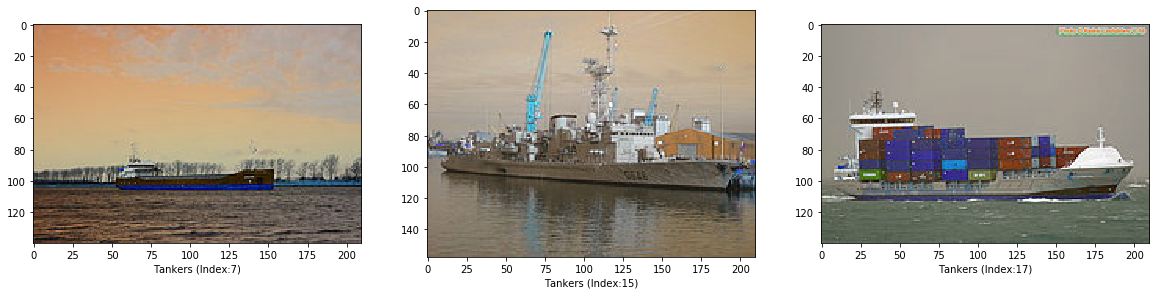

In [19]:
plot_class('Tankers')

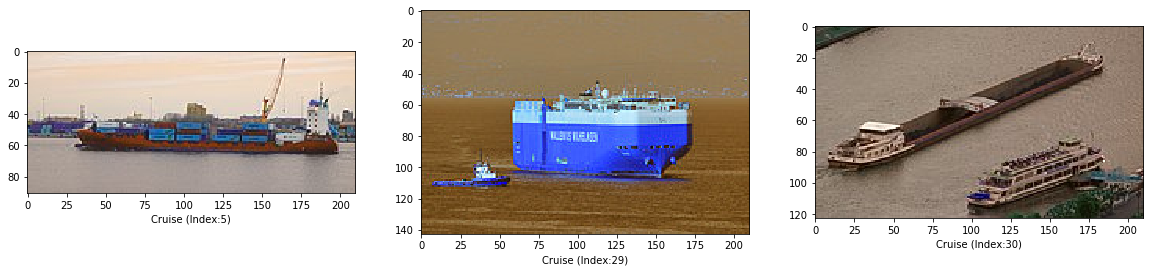

In [20]:
plot_class('Cruise')

These pictures seems to be taken from side and not from top (like picture taken from a satellite) except may be few of them which look like taken from above (although not from high above). We also noticed that all the pictures are of different sizes. we have to make sure they are of same sizes before modelling.

From deep learning context, we do not have very large number of images per category. So we will heavily depend on data augmentation, otherwise, it will easily cause overfitting.

### Modelling Approach

- i am using fastai datablock api to create our databunch and train model using cnn

In [21]:
# doc(src.transform)

Let's define the transformations to be done to the images.
- random flipping of the images `do_flip=True`. Tried with `False` as well.
- switch off vertical flipping (it's default behaviour). This option is useful when pictures are taken from high above.
- let's rotate the pictures a bit randomly `max_rotate=10` (it's already default ).
- zoom in a higher bit `max_zoom` (as we are dealing with ships picture that are small compared to overall image).
- `max_warp` is set to zero as it seems to perform better in this case.
- apply lighting and probability of affine function .
For details on transformation visit [here][1]

[1]: https://docs.fast.ai/vision.transform.html

In [22]:
##transformations to be done to images
tfms = get_transforms(do_flip=False,flip_vert=False ,max_rotate=10.0, max_zoom=1.22, max_lighting=0.22, max_warp=0.0, p_affine=0.75,
                      p_lighting=0.75)
#, xtra_tfms=zoom_crop(scale=(0.9,1.8), do_rand=True, p=0.8))

## create databunch of test set to be passed
test_img = ImageList.from_df(test_df, path=data_folder/'train', folder='images')

In [23]:
np.random.seed(145)
## create source of train image databunch
src = (ImageList.from_df(train_df, path=data_folder/'train', folder='images')
       .split_by_rand_pct(0.2)
       #.split_none()
       .label_from_df()
       .add_test(test_img))

Let's create our databunch. I will be using `size = 299` for modelling purpose, however let's try even higher size picture to improve accuracy further. But beware that we have to adjust batchsize accordingly to run out of memory. in case of 299 size `bs=32` is used while for 484 or even 599, a smaller batchsize should be used. 

The reflection padding mode seems to work better in this case (`padding_mode='reflection'`).      
we will use Squishing resize method.      
Finally, we normalize the parameters using imagenet_stats 

In [24]:
data = (src.transform(tfms, size=299,padding_mode='reflection',resize_method=ResizeMethod.SQUISH)
        .databunch(path='.', bs=32, device= torch.device('cuda:0')).normalize(imagenet_stats))

# data = (src.transform(tfms, size=484,padding_mode='reflection',resize_method=ResizeMethod.SQUISH)
#         .databunch(path='.', bs=16, device= torch.device('cuda:0')).normalize(imagenet_stats))

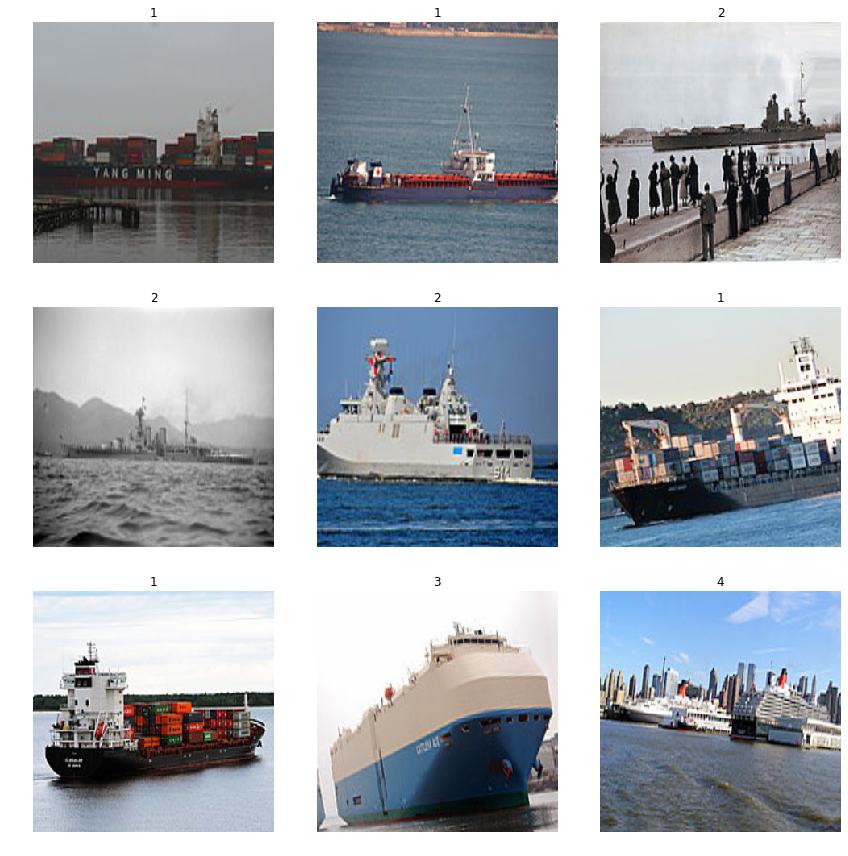

In [25]:
## lets see the few images from our databunch
data.show_batch(rows=3, figsize=(12,12))

In [26]:
print(data.classes)

[1, 2, 3, 4, 5]


In [27]:
# doc(cnn_learner)

Now we will create cnn learner. 

In [28]:
#lets create learner. tried with resnet152, densenet201, resnet101
learn = cnn_learner(data=data, base_arch=models.resnet101, metrics=[FBeta(beta=1, average='macro'), accuracy],
                    callback_fns=ShowGraph)

# learn = cnn_learner(data=data, base_arch=models.densenet161, metrics=[FBeta(beta=1, average='macro'), accuracy],
#                     callback_fns=ShowGraph).mixup()

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /tmp/.torch/models/resnet101-5d3b4d8f.pth
178728960it [00:01, 101918625.08it/s]


`mixup()` on the above learner refer to a pretty aberrant feature which seems very unfamailiar to us (human) however this technique works better for computers. Details of the paper can be found [here](https://arxiv.org/abs/1710.09412).  The theory behind is like this:
- we do not train dirctely on the raw data images instead the model is trained on mixes of images i.e. we add 2 or more images to combine a single picture by this: `new_image = t * image1 + (1-t) * image2` (not necessary to take only 2 images). By using this same technique, targets are changed as well `new_target = t * target1 + (1-t) * target2` ; where t is a float between 0 and 1.
- Let's take an example: we are training on cat/dog dataset and we mix 2 images (one of each kind) and we finally get a single image of like this. It not clear to us what image is this; may be 70% dog and 30% cat.
![image](https://docs.fast.ai/imgs/mixup.png)
- One  thing to note that, the mixup model may perform better than the regular one but when you compare the traing/validation losses, the mixup model has loss far greater than the regular one (although accuracy seems better in mixup model). This is because the mixup model predictions are less confident about the target. i.e. when we do prediction through our normal model, model seems pretty confident about the target (one target probability prediction will be close to 1 and others will be close to 0). When we predict through mixup model, the probabilities values of the targets will more likely to be close to one another).
For details visit [here](https://docs.fast.ai/callbacks.mixup.html)

In [29]:
#learn.opt_func = optim.Adam
#learn.crit = FocalLoss()
# learn_gen = None
# gc.collect()
# torch.cuda.empty_cache()
learn.summary()

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 150, 150]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 150, 150]       128        True      
______________________________________________________________________
ReLU                 [64, 150, 150]       0          False     
______________________________________________________________________
MaxPool2d            [64, 75, 75]         0          False     
______________________________________________________________________
Conv2d               [64, 75, 75]         4,096      False     
______________________________________________________________________
BatchNorm2d          [64, 75, 75]         128        True      
______________________________________________________________________
Conv2d               [64, 75, 75]         36,864     False     
______________________________________________________________

Learning rate finder plots lr vs loss relationship for a Learner. The idea is to reduce the amount of guesswork on picking a good starting learning rate.
If you pass `suggestion=True` in `learn.recorder.plot`, you will see the point where the gardient is the steepest with a
red dot on the graph. We can use that point as a first guess for an LR. Details can be found [here](https://docs.fast.ai/basic_train.html#lr_find)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.20E-03


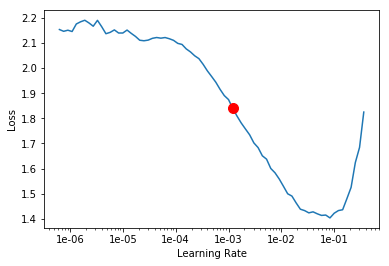

In [30]:
#lets find the correct learning rate to be used from lr finder
learn.lr_find()
learn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,f_beta,accuracy,time
0,0.693012,0.437668,0.865360,0.851200,01:09
1,0.469444,0.347338,0.886052,0.874400,01:07
2,0.357509,0.261099,0.911470,0.899200,01:06
3,0.290550,0.208829,0.941181,0.934400,01:06
4,0.215814,0.216067,0.934395,0.924000,01:06
5,0.179154,0.169092,0.947154,0.943200,01:06
6,0.152724,0.167678,0.943738,0.937600,01:06
7,0.113796,0.136149,0.960140,0.955200,01:06
8,0.085655,0.129778,0.962603,0.958400,01:06
9,0.063745,0.122865,0.965253,0.962400,01:06


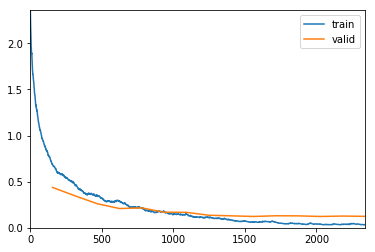

In [31]:
#lets start with steepset slope point. adding wd (weight decay) not to overfit as we are running 15 epochs 
lr = 3e-03
#learn.fit_one_cycle(10, slice(lr))
learn.fit_one_cycle(15, slice(lr), wd=0.2)

Now Unfreeze entire model.This Sets every layer group to trainable (i.e. `requires_grad=True`).

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 9.12E-07


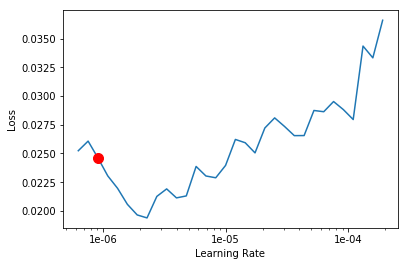

In [32]:
#lets plot the lr finder record
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,f_beta,accuracy,time
0,0.039074,0.140602,0.964227,0.960000,01:26
1,0.113811,0.186799,0.949743,0.945600,01:26
2,0.108368,0.171470,0.951571,0.945600,01:26
3,0.100596,0.163587,0.949775,0.943200,01:26
4,0.065034,0.128748,0.960905,0.956800,01:26
5,0.053749,0.104771,0.967083,0.962400,01:26
6,0.018688,0.099611,0.976395,0.972800,01:26
7,0.020925,0.100161,0.966996,0.962400,01:26
8,0.011317,0.084132,0.974451,0.971200,01:26
9,0.006725,0.088104,0.973582,0.969600,01:26


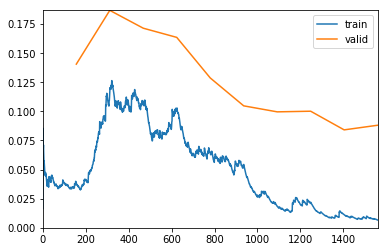

In [33]:
# train for  more cycles after unfreezing
learn.fit_one_cycle(10,slice(1e-05,lr/8),wd=0.15)
#learn.fit_one_cycle(10, slice(5e-06, lr/8))

lets freeze the all layers except last 3  as these are initial layers for finding recurring pattern/ shapes/corners etc. (not exactly helpful in finding ships). so its better not to change stats of those layers

In [34]:
learn.freeze_to(-3)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07


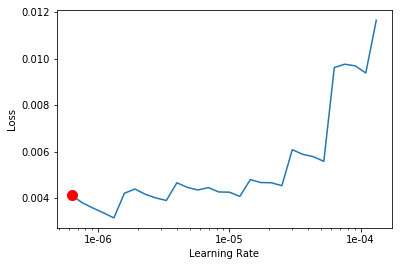

In [35]:
## finding the LR
learn.lr_find()
learn.recorder.plot(suggestion=True)

- Train for few  more cycles (we will be setting two LRs in below trainings: first one to train the initial layers and second to
train last layers ).    
- As initial layers' stats are imagenet stats which are helpful in finding patterns (discussed above) not 
the exact ships, so we will be training those layers with very low learning rates (to not to greatly change those initial layer
parameters)

epoch,train_loss,valid_loss,f_beta,accuracy,time
0,0.007210,0.089346,0.972702,0.968800,01:26
1,0.006115,0.097781,0.976330,0.972800,01:26
2,0.012017,0.119059,0.971187,0.967200,01:26
3,0.005724,0.091011,0.980566,0.977600,01:26
4,0.003263,0.091049,0.979732,0.976800,01:26
5,0.003649,0.104492,0.976228,0.972800,01:26


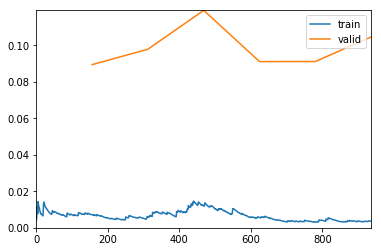

In [36]:
learn.fit_one_cycle(6, slice(1e-06, lr/10),wd=0.1)

In [37]:
## freezing initial all layers except last 2 layers
learn.freeze_to(-2)

epoch,train_loss,valid_loss,f_beta,accuracy,time
0,0.003603,0.090942,0.978328,0.975200,01:19
1,0.004921,0.097295,0.977824,0.974400,01:19
2,0.004648,0.099852,0.978789,0.976000,01:19
3,0.003861,0.102480,0.978478,0.975200,01:19
4,0.003376,0.099027,0.978838,0.976000,01:19
5,0.004127,0.116746,0.972591,0.968800,01:19


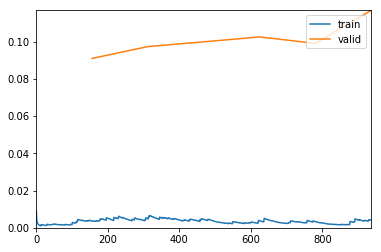

In [38]:
## training for few cylcles more
learn.fit_one_cycle(6, slice(5e-07, lr/20),wd=0.1)

In [39]:
learn.freeze_to(-1)

epoch,train_loss,valid_loss,f_beta,accuracy,time
0,0.002177,0.091834,0.980128,0.976800,01:06
1,0.001885,0.101840,0.979612,0.976800,01:06
2,0.001032,0.099598,0.979451,0.976800,01:06
3,0.003491,0.112226,0.976118,0.972800,01:06
4,0.002262,0.098231,0.980287,0.977600,01:06


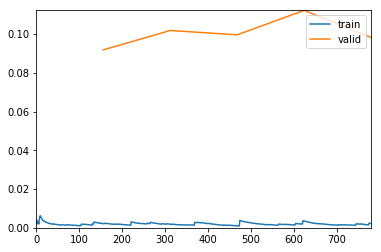

In [40]:
## training even more
learn.fit_one_cycle(5, slice(1e-07, lr/30),wd=0.05)

epoch,train_loss,valid_loss,f_beta,accuracy,time
0,0.003438,0.096617,0.979042,0.976000,01:06
1,0.001899,0.101581,0.980537,0.977600,01:06
2,0.001977,0.094166,0.979042,0.976000,01:06
3,0.002582,0.114533,0.975522,0.972000,01:06
4,0.001537,0.101362,0.979443,0.976800,01:06
5,0.001002,0.095346,0.979647,0.976800,01:06


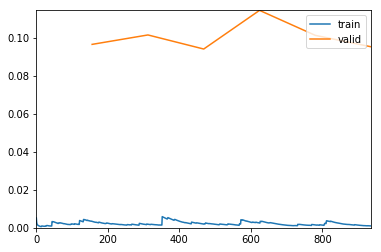

In [41]:
learn.fit_one_cycle(6, slice(1e-07, lr/100))

### Interpretation

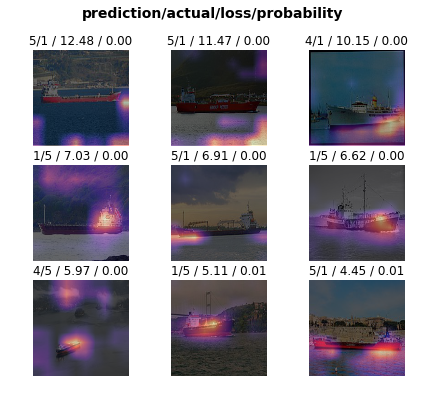

In [42]:
#lets see the most mis-classified images (on validation set)
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(9, figsize=(7,6))

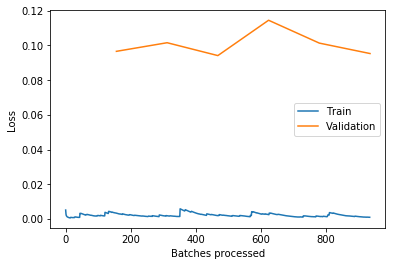

In [43]:
learn.recorder.plot_losses()

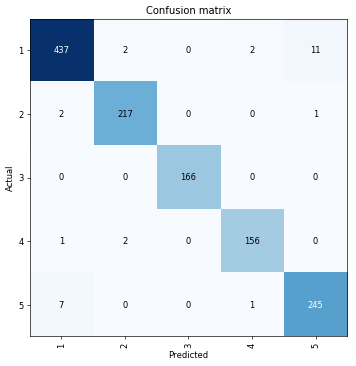

In [44]:
interp.plot_confusion_matrix(figsize=(6,6), dpi=60) ## on validation set

It seems like our model is finding difficult to distinguish between ship 1 (cargo) and 5 (tanker)

In [45]:
interp.most_confused(min_val=4) ## on validation set

[(1, 5, 11), (5, 1, 7)]

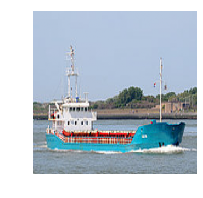

In [46]:
idx=1
x,y = data.valid_ds[idx]
x.show()

In [47]:
k = tensor([
    [0.  ,-5/3,1],
    [-5/3,-5/3,1],
    [1.  ,1   ,1],
]).expand(1,3,3,3)/6

In [48]:
t = data.valid_ds[1][0].data; t.shape

torch.Size([3, 299, 299])

In [49]:
edge = F.conv2d(t[None], k)

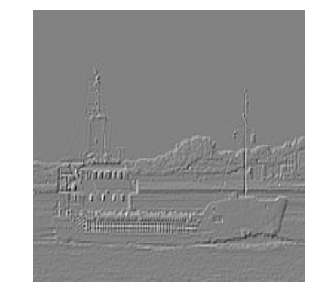

In [50]:
show_image(edge[0], figsize=(5,5));

In [51]:
m = learn.model.eval();
xb,_ = data.one_item(x)
xb_im = Image(data.denorm(xb)[0])
xb = xb.cuda()

In [52]:
def hooked_backward(cat=y):
    with hook_output(m[0]) as hook_a: 
        with hook_output(m[0], grad=True) as hook_g:
            preds = m(xb)
            preds[0,int(cat)].backward()
    return hook_a,hook_g

In [53]:
hook_a,hook_g = hooked_backward()
acts  = hook_a.stored[0].cpu()
acts.shape

torch.Size([2048, 10, 10])

In [54]:
avg_acts = acts.mean(0)
avg_acts.shape
torch.Size([11, 11])

torch.Size([11, 11])

In [55]:
def show_heatmap(hm):
    _,ax = plt.subplots()
    xb_im.show(ax)
    ax.imshow(hm, alpha=0.6, extent=(0,352,352,0),
              interpolation='bilinear', cmap='magma');

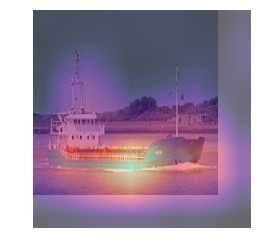

In [56]:
show_heatmap(avg_acts)

Predicted using TTA as it could improve accuracy further (Test time augmentation).
Applies Test Time Augmentation to our learner on the dataset.    
Here We take the average of our regular predictions (with a weight beta) with the average of predictions obtained through augmented 
versions of the training set (with a weight 1-beta). Details can be found [here](https://docs.fast.ai/basic_train.html#Test-time-augmentation)

In [57]:
##learn.TTA improves score further. lets see for the validation set
pred_val,y = learn.TTA(ds_type=DatasetType.Valid)
from sklearn.metrics import f1_score, accuracy_score
valid_preds = [np.argmax(pred_val[i])+1 for i in range(len(pred_val))]
valid_preds = np.array(valid_preds)
y = np.array(y+1)
accuracy_score(valid_preds,y),f1_score(valid_preds,y, average='micro')

(0.9808, 0.9808)

Now we have achieved more than 98% accuracy.

### Prediction

- Before predicting on the test set, i generally (sometimes) remove the validation set and try all these steps above on whole train set for modelling.  This is to produce  model not on 80% data but 100% data and predict the testset
- This can done by changing in one line in data creation i.e. change `.split_by_rand_pct(0.2)` to `.split_none()`.

In [58]:
preds,_ = learn.TTA(ds_type=DatasetType.Test)
#preds,_ = learn.get_preds(ds_type = DatasetType.Test)
labelled_preds = [np.argmax(preds[i])+1 for i in range(len(preds))]

labelled_preds = np.array(labelled_preds)

In [59]:
#create submission file
df = pd.DataFrame({'image':test_df['image'], 'category':labelled_preds}, columns=['image', 'category'])
df.to_csv('submission.csv', index=False)

In [60]:
## function to create download link
from IPython.display import HTML
def create_download_link(title = "Download CSV file", filename = "data.csv"):  
    html = '<a href={filename}>{title}</a>'
    html = html.format(title=title,filename=filename)
    return HTML(html)

In [61]:
create_download_link(filename = 'submission.csv')

In [62]:
df.category.unique()

array([4, 2, 5, 1, 3])

In [63]:
df.head()

,image,category
0,1007700.jpg,4
1,1011369.jpg,4
2,1051155.jpg,4
3,1062001.jpg,2
4,1069397.jpg,4


### Final submission

- At this point, i have submission files of around 22 which are created with different augmentation techniques, with/without mixup, different pretrained model (used resnet101, resnet152, densenet161, densenet169), different image sizes (tried with size 224, 299, 484, 599). All the prediction are based on TTA. 
- The final submission was created based on voting technique by all the submission predicted categories.
- I could have tried with predicting the probabilities of the image category of all these submissions and then the final submission could have been based on average of those probabilities values. But I am guessing there might have been one challenge: as mentioned above in the notebook, the mixup model predctions are less confident about the target and hence due to this the average probabilities could have been very different leading to different results (may be). 

For e.g. lets take cat/dog image: without mixup, the model predicts cat (prob: 0.94) and dog (0.06) while the mixup model predicts cat (prob:0.56) and dog (0.44) and the average of these 2 models is cat( 0.75) and dog(0.25). Well this might seems fine, however let's imagine we have more target categories to predict, and in this scenario the mixup model probabilities could alter the average probabilities. 